In [1]:
# Configs
%load_ext autoreload
%autoreload 3
import sys
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import CellType
from src_code.data_utils.prompt_utils import prompt_generator
from src_code.model_utils.gemma3 import Gemma3Model
from src_code.eval_utils.eval import calculate_score, eval_results

import ast

model = Gemma3Model()
EVAL_NUM = 100


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Example

In [ ]:
reuslt = model.inference(
    "Describe this image in detail.", 
    img="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
)
print(reuslt)

# Our dataset

In [2]:
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")

# ASCII Input Only

In [3]:
img, grid_world = dataset[10]
prompt_img = prompt_generator(grid_world, pure_language=False, img=None, img_symbol="This image")
print(prompt_img)

Here is the grid world:
 # # # # # # #
 # . . . . . #
 # # . . . . #
 # . # . . . #
 # . . . G . #
 # S . # . . #
 # # # # # # #

The S cell is the starting cell,
the G cell is the goal cell,
the # cells are obstacles,
and the . cells are free cells.

Rules:
The grid size is 5x5
The path must not pass through the obstacles.
You can move up, down, left, or right from one cell to another.
You cannot move diagonally.
The path must be the shortest path from the starting cell to the goal cell.
The output should be a sequence of steps to reach the goal cell.
Output the steps only.

Actions:
Only give me the steps, like 'go up', 'go down', 'go left', 'go right' or 'not solvable'
go up: move one cell up
go down: move one cell down
go left: move one cell left
go right: move one cell right
not solvable: it is not possible to go the the goal cell from the start cell

Output example:
('go up', 'go right', 'go right', 'go down', 'go right') or ('not solvable')

Can you find the path from the starti

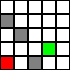

In [4]:
img

# Inference

In [ ]:
reuslt = model.inference(prompt_img, img=None)
print(reuslt)

# Eval

In [ ]:
path_results_img = []
path_results_ascii = []
path_results_coor = []
path_results_img_raw = []
path_results_ascii_raw = []
path_results_coor_raw = []
EVAL_NUM = 1
for i in range(EVAL_NUM):
    img_rgb, grid_world = dataset[i]
    prompt_img = prompt_generator(grid_world, pure_language=False, img=True, img_symbol="This image")
    prompt_ascii = prompt_generator(grid_world, pure_language=False)
    prompt_coor = prompt_generator(grid_world, pure_language=True)
    path_result_img = model.inference(
        prompt_img, 
        img=img_rgb
    )
    patj_result_ascii = model.inference(
        prompt_ascii
    )
    path_result_coor = model.inference(
        prompt_coor
    )
    path_results_img_raw.append(path_result_img)
    path_results_ascii_raw.append(patj_result_ascii)
    path_results_coor_raw.append(path_result_coor)
    try:
        print(f"{path_result_img=}")
        path_result_img = ast.literal_eval(path_result_img)
        print(f"{path_result_img=}")
        path_results_img.append(path_result_img)
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_img")
    try:
        print(f"{patj_result_ascii=}")
        path_result_ascii = ast.literal_eval(patj_result_ascii)
        path_results_ascii.append(path_result_ascii)
        print(f"{path_result_ascii=}")
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_ascii")
    try:
        print(f"{path_result_coor=}")
        path_result_coor = ast.literal_eval(path_result_coor)
        print(f"{path_result_coor=}")
        path_results_coor.append(path_result_coor)
    except Exception as e:
        print(f"{e=}")
        print(f"Fail to parse path_result_coor")
    print(f"{grid_world.a_star()=}\n")

eval_result_img = eval_results(path_results_img, dataset)
eval_result_ascii = eval_results(path_results_ascii, dataset)
eval_result_coor = eval_results(path_results_coor, dataset)
print(f"{eval_result_img=}")
print(f"{eval_result_ascii=}")
print(f"{eval_result_coor=}")
result = {"img": eval_result_img, "ascii": eval_result_ascii, "coor": eval_result_coor}

In [ ]:
result

In [ ]:
import json

with open('../result_gemma3_100.json', 'w') as f:
    json.dump(result, f, indent=4)

with open('../gemma3_results_img_raw.json', 'w') as f:
    json.dump(path_results_img_raw, f, indent=4)

with open('../gemma3_results_ascii_raw.json', 'w') as f:
    json.dump(path_results_ascii_raw, f, indent=4)

with open('../gemma3_results_coor_raw.json', 'w') as f:
    json.dump(path_results_coor_raw, f, indent=4)

In [ ]:
%load_ext autoreload
%autoreload 3
import sys
sys.path.insert(0, "../")
import json
from src_code.data_utils.dataset import GridDataset
from src_code.eval_utils.eval import calculate_score, eval_results
import ast
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".")

In [ ]:
# read the results
path_results_img = []
path_results_ascii = []
path_results_coor = []
with open('../gemma3_results_img_raw.json', 'r') as f:
    path_results_img_raw = json.load(f)

with open('../gemma3_results_ascii_raw.json', 'r') as f:
    path_results_ascii_raw = json.load(f)

with open('../gemma3_results_coor_raw.json', 'r') as f:
    path_results_coor_raw = json.load(f)

for i, content in enumerate(path_results_img_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("Imgae result parsing error")
    path_results_img.append(r)

for i, content in enumerate(path_results_ascii_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("Ascii result parsing error")
    path_results_ascii.append(r)

for i, content in enumerate(path_results_coor_raw):
    r = None
    try:
        r = ast.literal_eval(content)
        if type(r) == str:
            r = (r,)
    except Exception as e:
        print("coor result parsing error")
    path_results_coor.append(r)

eval_result_img = eval_results(path_results_img, dataset)
eval_result_ascii = eval_results(path_results_ascii, dataset)
eval_result_coor = eval_results(path_results_coor, dataset)
print(f"{eval_result_img=}")
print(f"{eval_result_ascii=}")
print(f"{eval_result_coor=}")
result = {"img": eval_result_img, "ascii": eval_result_ascii, "coor": eval_result_coor}